In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import mean_squared_error


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1)

### Technical and Macro signals.

In [3]:
df = pd.read_csv("data_final.csv")
df = df.sort_values("observation_date")
df = df.reset_index(drop=True)

macro_features = [
    'FEDFUNDS',
    'UNRATE',
    'GS10',
    'DTWEXBGS',
    'DCOILWTICO',
    'GOLD',
    'MOVE',
    'VIXCLS'
]

technical_features = [
    'SMA_10',
    'SMA_50',
    'EMA_10',
    'EMA_50',
    'ROC_10',
    'RSI_14',
    'BB_upper',
    'BB_lower',
    'Volatility_20'
]

df['log_return'] = np.log(df['SP500'] / df['SP500'].shift(1))
df = df.dropna().reset_index(drop=True)

target = 'log_return'

X_macro = df[macro_features].values
y_macro = df[[target]].values
X_technical = df[technical_features].values
y_technical = df[[target]].values


/var/folders/5t/_mmy5kjx1yn0xc44547b62pr0000gn/T/ipykernel_44864/2527218873.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .

Epoch 1/1000 | FXNet Loss: 1.4207
Epoch 2/1000 | FXNet Loss: 0.2595
Epoch 3/1000 | FXNet Loss: 0.2222
Epoch 4/1000 | FXNet Loss: 0.2066
Epoch 5/1000 | FXNet Loss: 0.1976
Epoch 6/1000 | FXNet Loss: 0.1918
Epoch 7/1000 | FXNet Loss: 0.1867
Epoch 8/1000 | FXNet Loss: 0.1815
Epoch 5/1000 | FXNet Loss: 0.1976
Epoch 6/1000 | FXNet Loss: 0.1918
Epoch 7/1000 | FXNet Loss: 0.1867
Epoch 8/1000 | FXNet Loss: 0.1815
Epoch 9/1000 | FXNet Loss: 0.1769
Epoch 10/1000 | FXNet Loss: 0.1758
Epoch 11/1000 | FXNet Loss: 0.1718
Epoch 12/1000 | FXNet Loss: 0.1702
Epoch 9/1000 | FXNet Loss: 0.1769
Epoch 10/1000 | FXNet Loss: 0.1758
Epoch 11/1000 | FXNet Loss: 0.1718
Epoch 12/1000 | FXNet Loss: 0.1702
Epoch 13/1000 | FXNet Loss: 0.1682
Epoch 14/1000 | FXNet Loss: 0.1654
Epoch 15/1000 | FXNet Loss: 0.1656
Epoch 16/1000 | FXNet Loss: 0.1635
Epoch 13/1000 | FXNet Loss: 0.1682
Epoch 14/1000 | FXNet Loss: 0.1654
Epoch 15/1000 | FXNet Loss: 0.1656
Epoch 16/1000 | FXNet Loss: 0.1635
Epoch 17/1000 | FXNet Loss: 0.1595

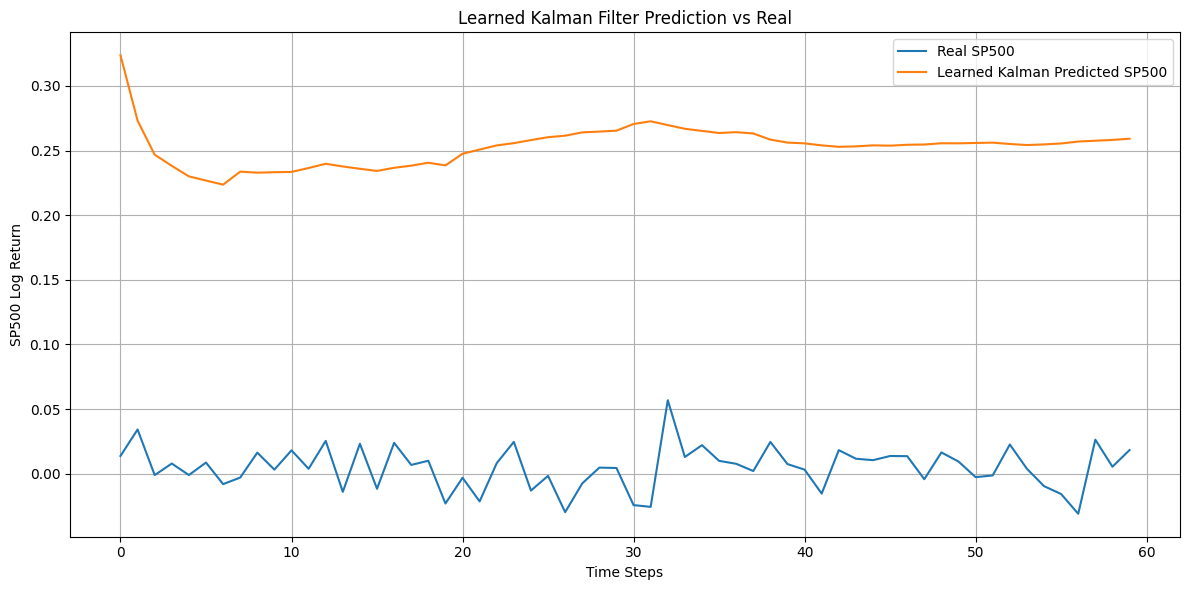

Mean Squared Error: 0.061998
Directional Accuracy (Kalman): 49.15%


In [4]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))
    return X[:train_end], y[:train_end], X[train_end:val_end], y[train_end:val_end], X[val_end:], y[val_end:]

X_macro = df[macro_features].values
y_macro = df[['log_return']].values
seq_length = 20

X_macro_seq_raw, y_macro_seq_raw = create_sequences(X_macro, y_macro, seq_length)

X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = train_val_test_split(X_macro_seq_raw, y_macro_seq_raw)

macro_scaler = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = macro_scaler.fit_transform(X_train_flat).reshape(X_train_raw.shape)
X_val_scaled = macro_scaler.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test_scaled = macro_scaler.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled = y_scaler.transform(y_val_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)

class FXNet(nn.Module):
    def __init__(self, state_dim, hidden_dim=256):
        super(FXNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )

    def forward(self, x):
        return self.net(x)

def prepare_fx_training_data(X_seq):
    X_flat = X_seq.view(-1, X_seq.shape[2])
    X_t = X_flat[:-1]
    X_t1 = X_flat[1:]
    return X_t, X_t1

def train_fx_net(X_train, device, epochs=1000, lr=0.001):
    input_dim = X_train.shape[2]
    fx_net = FXNet(input_dim).to(device)

    x_t, x_t1 = prepare_fx_training_data(X_train)
    dataset = DataLoader(TensorDataset(x_t, x_t1), batch_size=128, shuffle=True)

    optimizer = torch.optim.Adam(fx_net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    fx_net.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in dataset:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = fx_net(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | FXNet Loss: {total_loss:.4f}")

    torch.save(fx_net, "fxnet_macro.pth")
    return fx_net.eval()

class LearnedKalmanFilter:
    def __init__(self, fx_net, dim_x, dim_z):
        self.fx_net = fx_net.eval()
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.H = np.eye(dim_z, dim_x)
        self.R = np.eye(dim_z) * 0.4
        self.Q = np.eye(dim_x) * 0.1
        self.P = np.eye(dim_x)
        self.x = np.zeros((dim_x,))

    def reset(self, x0=None):
        self.x = x0 if x0 is not None else np.zeros((self.dim_x,))
        self.P = np.eye(self.dim_x)

    def predict(self):
        x_tensor = torch.tensor(self.x, dtype=torch.float32).unsqueeze(0).to(next(self.fx_net.parameters()).device)
        with torch.no_grad():
            self.x = self.fx_net(x_tensor).squeeze(0).cpu().numpy()
        self.P = self.P + self.Q

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.dim_x) - K @ self.H) @ self.P

    def run(self, data):
        self.reset(data[0])
        preds = []
        for z in data:
            self.predict()
            self.update(z)
            preds.append(self.x.copy())
        return np.array(preds)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fx_net = train_fx_net(X_train, device)
kf = LearnedKalmanFilter(fx_net, dim_x=X_test.shape[2], dim_z=X_test.shape[2])

X_test_last_step = X_test[:, -1, :].cpu().numpy()
kf_preds = kf.run(X_test_last_step[:len(y_test)])

sp500_real = y_scaler.inverse_transform(y_test.cpu().numpy())
sp500_pred = y_scaler.inverse_transform(kf_preds[:, 0].reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label="Real SP500")
plt.plot(sp500_pred, label="Learned Kalman Predicted SP500")
plt.xlabel("Time Steps")
plt.ylabel("SP500 Log Return")
plt.title("Learned Kalman Filter Prediction vs Real")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real_diff = np.sign(np.diff(sp500_real.flatten()))
pred_diff = np.sign(np.diff(sp500_pred.flatten()))
directional_accuracy = np.mean(real_diff == pred_diff)
mse = mean_squared_error(sp500_real, sp500_pred)
print(f"Mean Squared Error: {mse:.6f}")
print(f"Directional Accuracy (Kalman): {directional_accuracy:.2%}")



In [5]:
real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))

directional_accuracy = np.mean(real_diff == pred_diff)
print(f"Directional Accuracy: {directional_accuracy:.2%}")

Directional Accuracy: 49.15%


Epoch 1/1000 | FXNet Loss: 1.0649
Epoch 2/1000 | FXNet Loss: 0.2031
Epoch 3/1000 | FXNet Loss: 0.1772
Epoch 4/1000 | FXNet Loss: 0.1640
Epoch 3/1000 | FXNet Loss: 0.1772
Epoch 4/1000 | FXNet Loss: 0.1640
Epoch 5/1000 | FXNet Loss: 0.1588
Epoch 6/1000 | FXNet Loss: 0.1529
Epoch 5/1000 | FXNet Loss: 0.1588
Epoch 6/1000 | FXNet Loss: 0.1529
Epoch 7/1000 | FXNet Loss: 0.1503
Epoch 8/1000 | FXNet Loss: 0.1501
Epoch 7/1000 | FXNet Loss: 0.1503
Epoch 8/1000 | FXNet Loss: 0.1501
Epoch 9/1000 | FXNet Loss: 0.1459
Epoch 10/1000 | FXNet Loss: 0.1441
Epoch 9/1000 | FXNet Loss: 0.1459
Epoch 10/1000 | FXNet Loss: 0.1441
Epoch 11/1000 | FXNet Loss: 0.1428
Epoch 12/1000 | FXNet Loss: 0.1422
Epoch 11/1000 | FXNet Loss: 0.1428
Epoch 12/1000 | FXNet Loss: 0.1422
Epoch 13/1000 | FXNet Loss: 0.1409
Epoch 14/1000 | FXNet Loss: 0.1387
Epoch 13/1000 | FXNet Loss: 0.1409
Epoch 14/1000 | FXNet Loss: 0.1387
Epoch 15/1000 | FXNet Loss: 0.1404
Epoch 16/1000 | FXNet Loss: 0.1377
Epoch 15/1000 | FXNet Loss: 0.1404
E

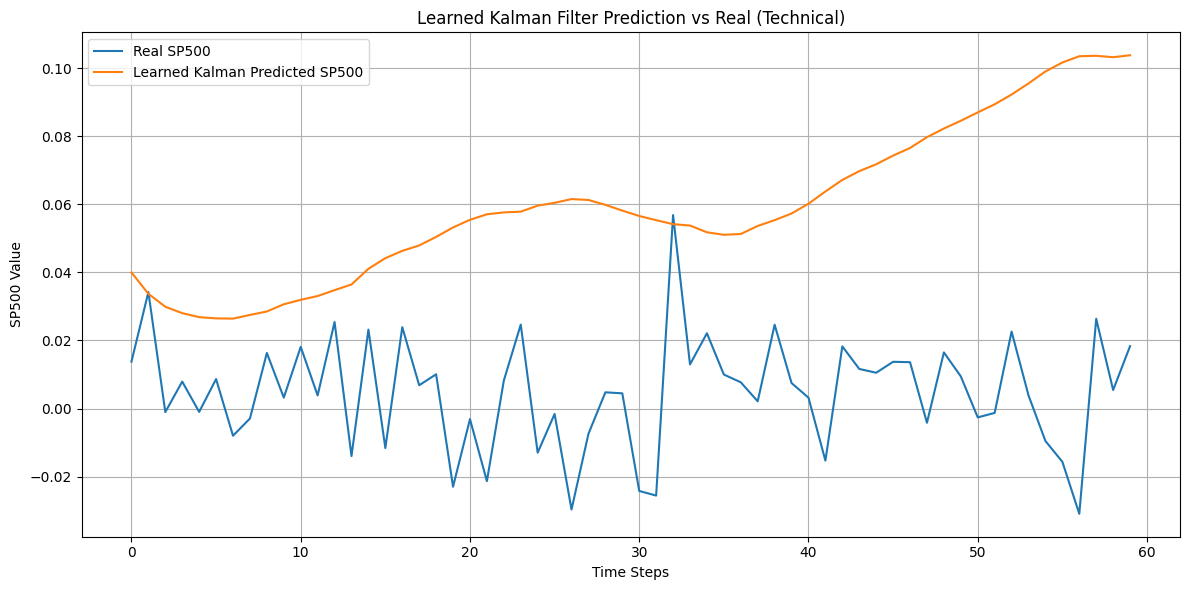

Mean Squared Error: 0.003823
Directional Accuracy (Technical): 47.46%


In [6]:
class FXNet(nn.Module):
    def __init__(self, state_dim, hidden_dim=256):
        super(FXNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )

    def forward(self, x):
        return self.net(x)

def prepare_fx_training_data(X_seq):
    X_flat = X_seq.view(-1, X_seq.shape[2])
    X_t = X_flat[:-1]
    X_t1 = X_flat[1:]
    return X_t, X_t1

def train_fx_net(X_train, device, epochs=1000, lr=0.001):
    input_dim = X_train.shape[2]
    fx_net = FXNet(input_dim).to(device)

    x_t, x_t1 = prepare_fx_training_data(X_train)
    dataset = DataLoader(TensorDataset(x_t, x_t1), batch_size=128, shuffle=True)

    optimizer = torch.optim.Adam(fx_net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    fx_net.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in dataset:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = fx_net(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | FXNet Loss: {total_loss:.4f}")
    
    torch.save(fx_net, "fxnet_technical.pth")
    return fx_net.eval()

class LearnedKalmanFilter:
    def __init__(self, fx_net, dim_x, dim_z):
        self.fx_net = fx_net.eval()
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.H = np.eye(dim_z, dim_x)
        self.R = np.eye(dim_z) * 0.4
        self.Q = np.eye(dim_x) * 0.1
        self.P = np.eye(dim_x)
        self.x = np.zeros((dim_x,))

    def reset(self, x0=None):
        self.x = x0 if x0 is not None else np.zeros((self.dim_x,))
        self.P = np.eye(self.dim_x)

    def predict(self):
        x_tensor = torch.tensor(self.x, dtype=torch.float32).unsqueeze(0).to(next(self.fx_net.parameters()).device)
        with torch.no_grad():
            self.x = self.fx_net(x_tensor).squeeze(0).cpu().numpy()
        self.P = self.P + self.Q

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.dim_x) - K @ self.H) @ self.P

    def run(self, data):
        self.reset(data[0])
        preds = []
        for z in data:
            self.predict()
            self.update(z)
            preds.append(self.x.copy())
        return np.array(preds)

X_technical = df[technical_features].values
y = df[['log_return']].values
seq_length = 20

X_technical_seq_raw, y_seq_raw = create_sequences(X_technical, y, seq_length)

X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = train_val_test_split(
    X_technical_seq_raw, y_seq_raw
)

scaler_tech = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = scaler_tech.fit_transform(X_train_flat).reshape(X_train_raw.shape)
X_val_scaled = scaler_tech.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test_scaled = scaler_tech.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled = y_scaler.transform(y_val_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)

fx_net = train_fx_net(X_train, device)
kf = LearnedKalmanFilter(fx_net, dim_x=X_test.shape[2], dim_z=X_test.shape[2])
X_test_last_step = X_test[:, -1, :].cpu().numpy()
kf_preds = kf.run(X_test_last_step[:len(y_test)])

sp500_real = y_scaler.inverse_transform(y_test.cpu().numpy())
sp500_pred = y_scaler.inverse_transform(kf_preds[:, 0].reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label="Real SP500")
plt.plot(sp500_pred, label="Learned Kalman Predicted SP500")
plt.xlabel("Time Steps")
plt.ylabel("SP500 Value")
plt.title("Learned Kalman Filter Prediction vs Real (Technical)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
mse = mean_squared_error(sp500_real, sp500_pred)
print(f"Mean Squared Error: {mse:.6f}")
print(f"Directional Accuracy (Technical): {directional_accuracy:.2%}")


Epoch 1/1000 | FXNet Loss: 1.5951
Epoch 2/1000 | FXNet Loss: 0.2823
Epoch 3/1000 | FXNet Loss: 0.2201
Epoch 4/1000 | FXNet Loss: 0.2002
Epoch 2/1000 | FXNet Loss: 0.2823
Epoch 3/1000 | FXNet Loss: 0.2201
Epoch 4/1000 | FXNet Loss: 0.2002
Epoch 5/1000 | FXNet Loss: 0.1909
Epoch 5/1000 | FXNet Loss: 0.1909
Epoch 6/1000 | FXNet Loss: 0.1839
Epoch 7/1000 | FXNet Loss: 0.1791
Epoch 8/1000 | FXNet Loss: 0.1724
Epoch 6/1000 | FXNet Loss: 0.1839
Epoch 7/1000 | FXNet Loss: 0.1791
Epoch 8/1000 | FXNet Loss: 0.1724
Epoch 9/1000 | FXNet Loss: 0.1703
Epoch 9/1000 | FXNet Loss: 0.1703
Epoch 10/1000 | FXNet Loss: 0.1670
Epoch 11/1000 | FXNet Loss: 0.1645
Epoch 12/1000 | FXNet Loss: 0.1605
Epoch 10/1000 | FXNet Loss: 0.1670
Epoch 11/1000 | FXNet Loss: 0.1645
Epoch 12/1000 | FXNet Loss: 0.1605
Epoch 13/1000 | FXNet Loss: 0.1594
Epoch 13/1000 | FXNet Loss: 0.1594
Epoch 14/1000 | FXNet Loss: 0.1560
Epoch 15/1000 | FXNet Loss: 0.1535
Epoch 16/1000 | FXNet Loss: 0.1541
Epoch 14/1000 | FXNet Loss: 0.1560
Ep

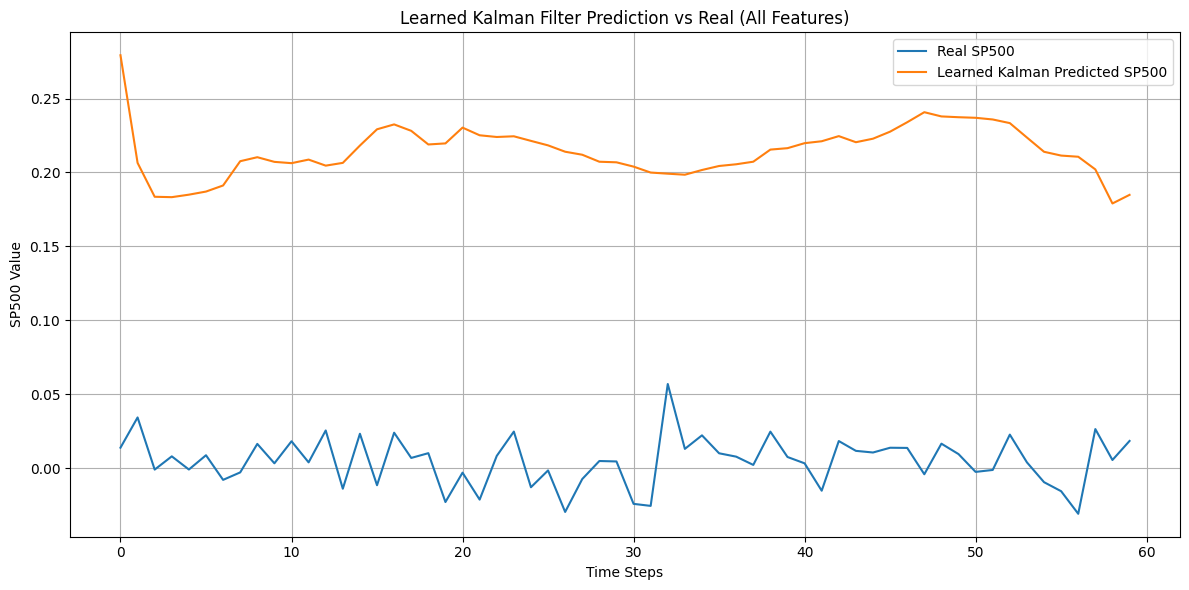

Mean Squared Error: 0.044535
Directional Accuracy (All Features): 50.85%


In [7]:
class FXNet(nn.Module):
    def __init__(self, state_dim, hidden_dim=256):
        super(FXNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )

    def forward(self, x):
        return self.net(x)

def prepare_fx_training_data(X_seq):
    X_flat = X_seq.view(-1, X_seq.shape[2])
    X_t = X_flat[:-1]
    X_t1 = X_flat[1:]
    return X_t, X_t1

def train_fx_net(X_train, device, epochs=1000, lr=0.001):
    input_dim = X_train.shape[2]
    fx_net = FXNet(input_dim).to(device)

    x_t, x_t1 = prepare_fx_training_data(X_train)
    dataset = DataLoader(TensorDataset(x_t, x_t1), batch_size=128, shuffle=True)

    optimizer = torch.optim.Adam(fx_net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    fx_net.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in dataset:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = fx_net(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | FXNet Loss: {total_loss:.4f}")
        
    torch.save(fx_net, "fxnet_full.pth")
    return fx_net.eval()


class LearnedKalmanFilter:
    def __init__(self, fx_net, dim_x, dim_z):
        self.fx_net = fx_net.eval()
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.H = np.eye(dim_z, dim_x)
        self.R = np.eye(dim_z) * 0.4
        self.Q = np.eye(dim_x) * 0.1
        self.P = np.eye(dim_x)
        self.x = np.zeros((dim_x,))

    def reset(self, x0=None):
        self.x = x0 if x0 is not None else np.zeros((self.dim_x,))
        self.P = np.eye(self.dim_x)

    def predict(self):
        x_tensor = torch.tensor(self.x, dtype=torch.float32).unsqueeze(0).to(next(self.fx_net.parameters()).device)
        with torch.no_grad():
            self.x = self.fx_net(x_tensor).squeeze(0).cpu().numpy()
        self.P = self.P + self.Q

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.dim_x) - K @ self.H) @ self.P

    def run(self, data):
        self.reset(data[0])
        preds = []
        for z in data:
            self.predict()
            self.update(z)
            preds.append(self.x.copy())
        return np.array(preds)

features = macro_features + technical_features
X_all = df[features].values
y_all = df[['log_return']].values
seq_length = 20

X_all_seq_raw, y_all_seq_raw = create_sequences(X_all, y_all, seq_length)

X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = train_val_test_split(
    X_all_seq_raw, y_all_seq_raw
)

scaler_all = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = scaler_all.fit_transform(X_train_flat).reshape(X_train_raw.shape)
X_val_scaled = scaler_all.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test_scaled = scaler_all.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled = y_scaler.transform(y_val_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train_all = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_all = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_all = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_all = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test_all = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_all = torch.tensor(y_test_scaled, dtype=torch.float32)

fx_net = train_fx_net(X_train_all, device)
kf = LearnedKalmanFilter(fx_net, dim_x=X_test_all.shape[2], dim_z=X_test_all.shape[2])
X_test_last_step = X_test_all[:, -1, :].cpu().numpy()
kf_preds = kf.run(X_test_last_step[:len(y_test_all)])

sp500_real = y_scaler.inverse_transform(y_test_all.cpu().numpy())
sp500_pred = y_scaler.inverse_transform(kf_preds[:, 0].reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label="Real SP500")
plt.plot(sp500_pred, label="Learned Kalman Predicted SP500")
plt.xlabel("Time Steps")
plt.ylabel("SP500 Value")
plt.title("Learned Kalman Filter Prediction vs Real (All Features)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
mse = mean_squared_error(sp500_real, sp500_pred)
print(f"Mean Squared Error: {mse:.6f}")
print(f"Directional Accuracy (All Features): {directional_accuracy:.2%}")
